# drive 마운트, seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [ ]:
train_data1  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data1 = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

In [ ]:
train_data1.columns = train_data1.columns.str.replace('fog_train.', '')
test_data1.columns = test_data1.columns.str.replace('fog_test.', '')

In [ ]:
train_data1['stn_id'].value_counts().sort_index()

stn_id
AA    157823
AB    157823
AC    157823
AD    157823
AE    157823
AF    157823
AG    157823
AH    157823
BA    157823
BB    157823
BC    157823
BD    157823
CA    157823
CB    157823
DA    157823
DB    157823
DC    157823
EA    157823
EB    157823
EC    157822
Name: count, dtype: int64

In [ ]:
test_data1['stn_id'].value_counts().sort_index()

fog_test.stn_id
AI    52560
BE    52560
CC    52560
DD    52560
ED    52560
Name: count, dtype: int64

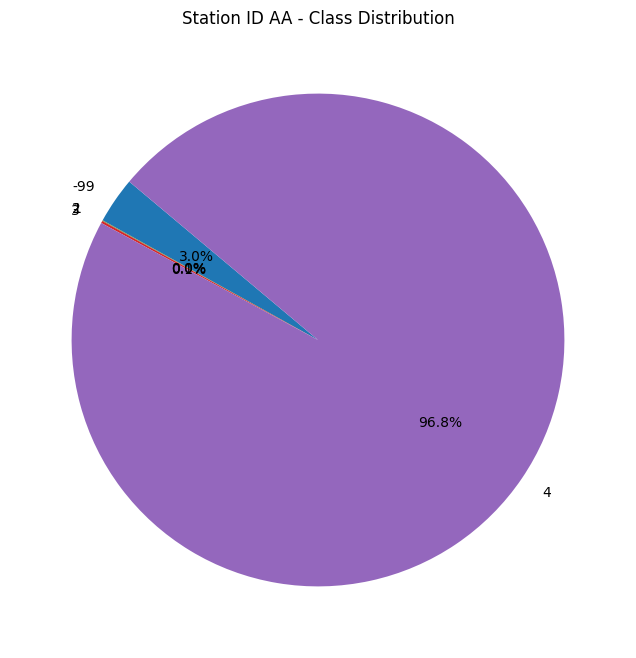

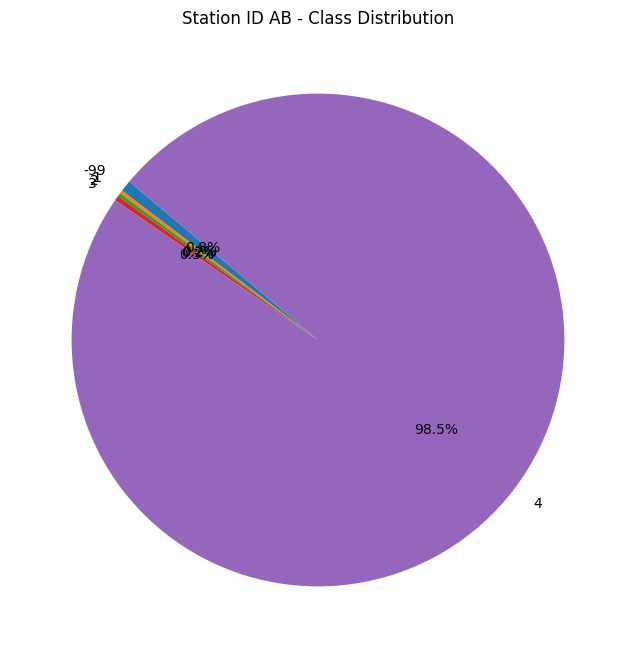

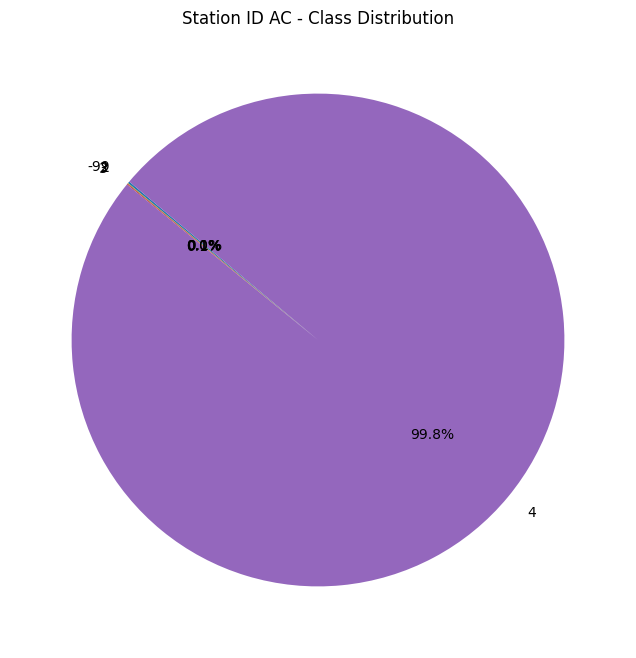

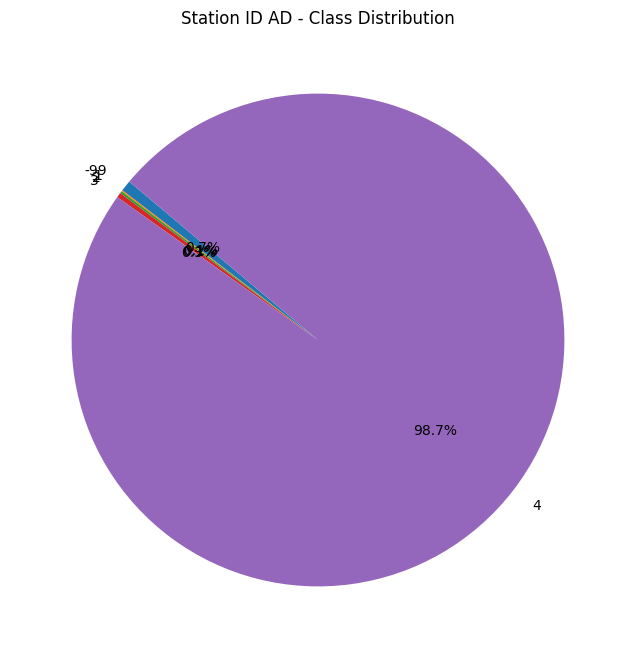

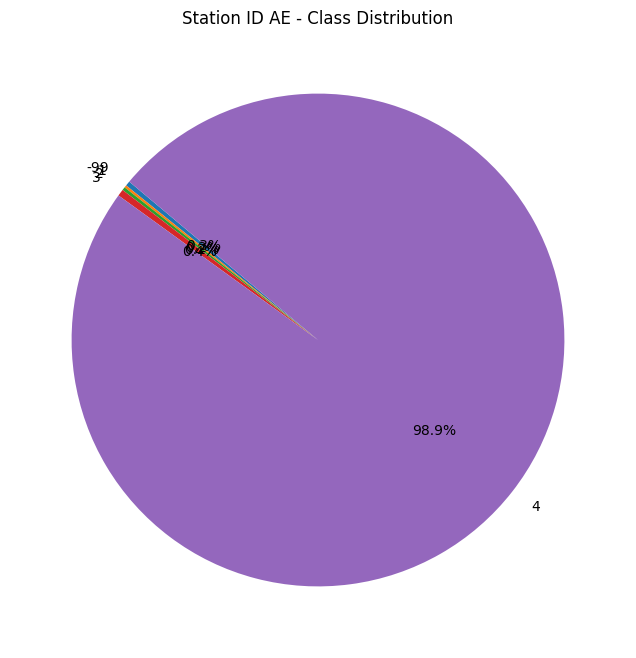

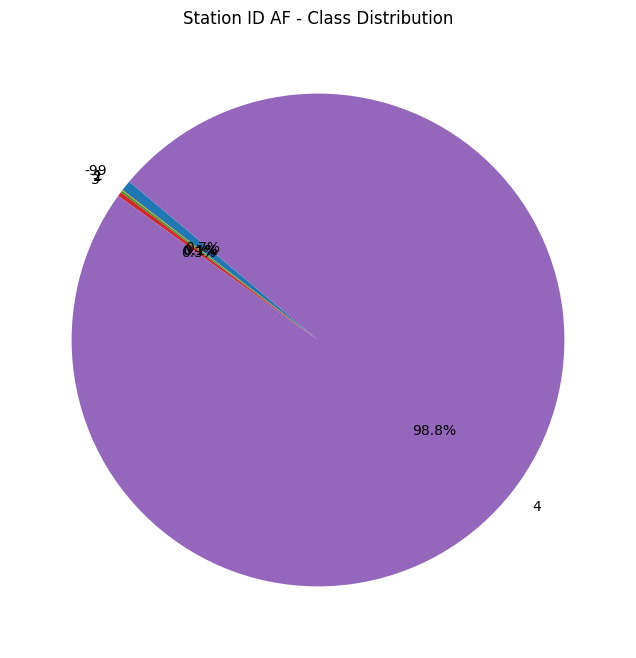

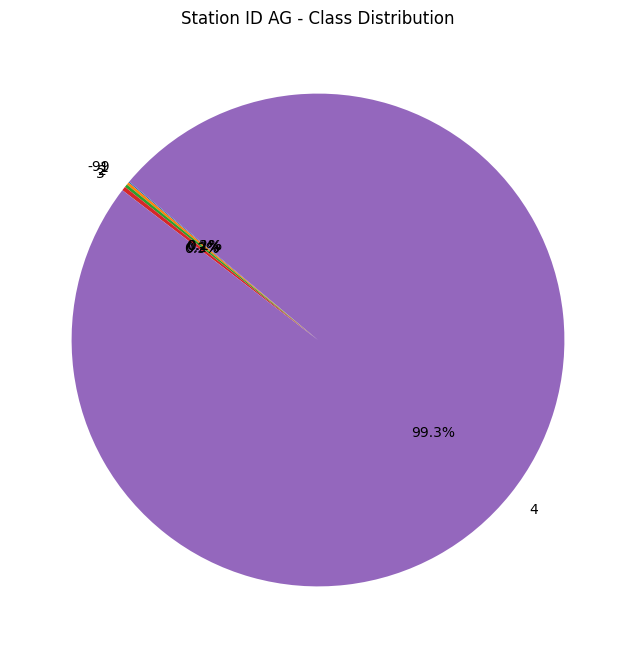

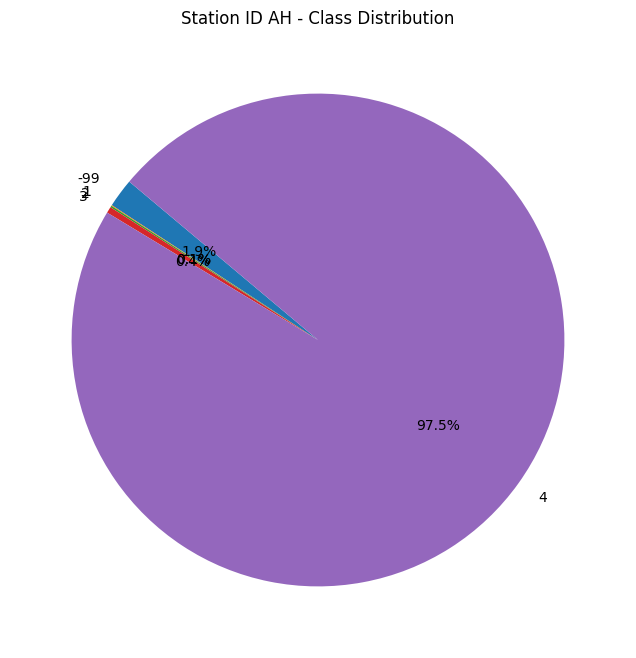

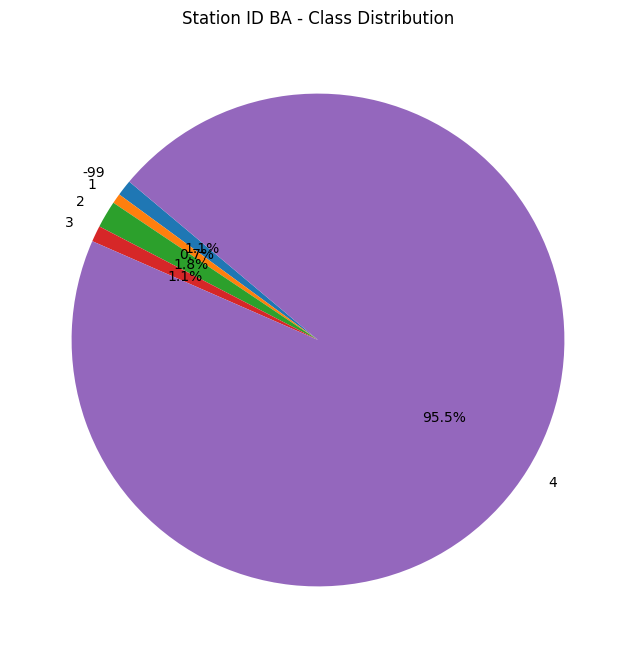

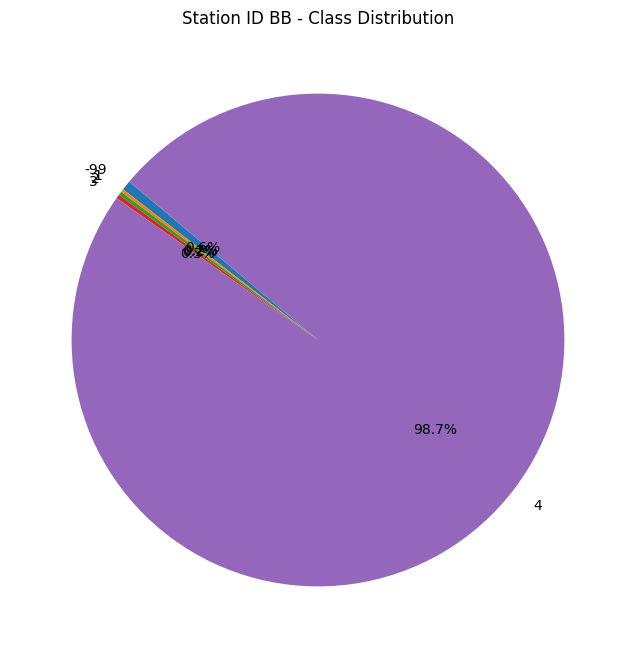

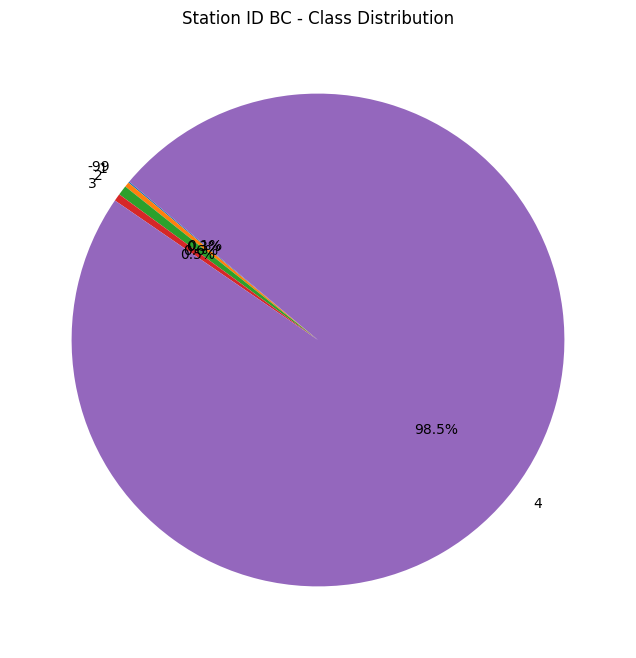

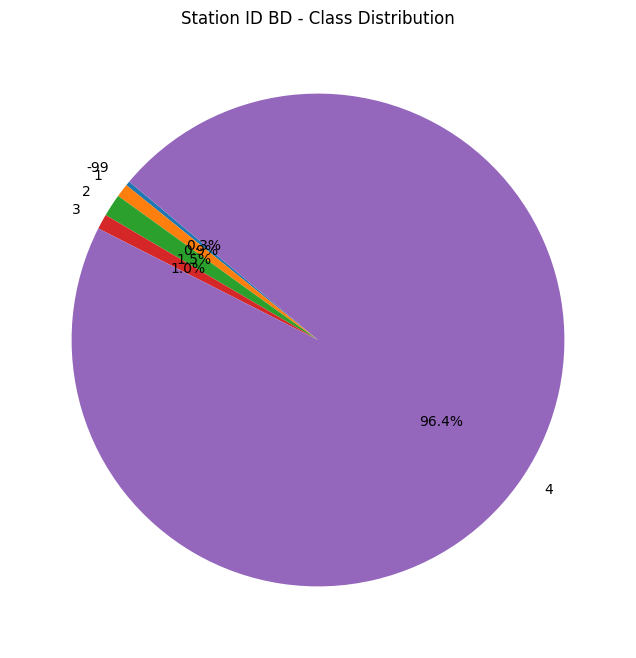

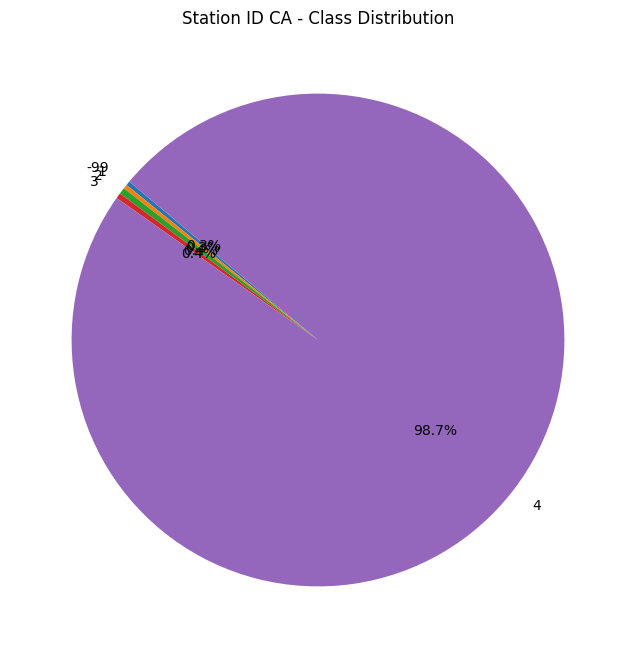

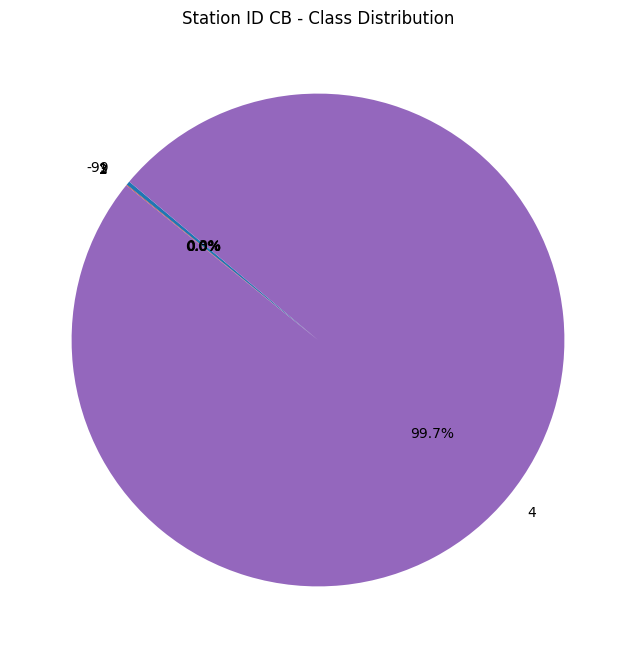

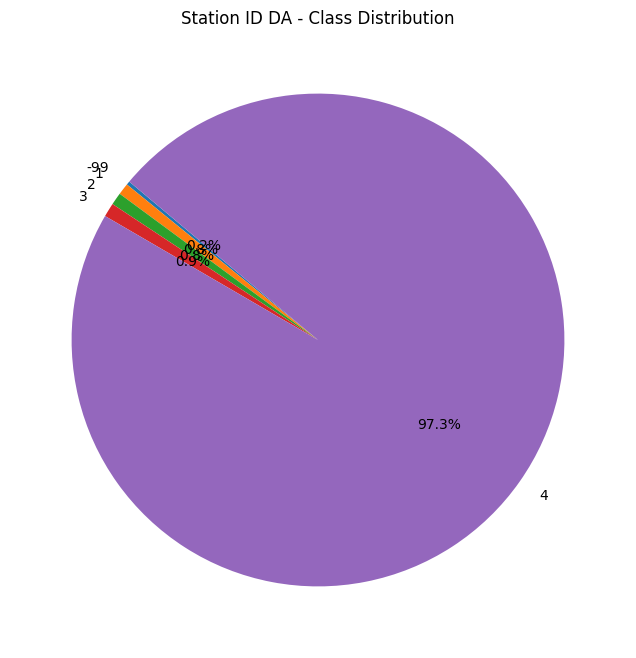

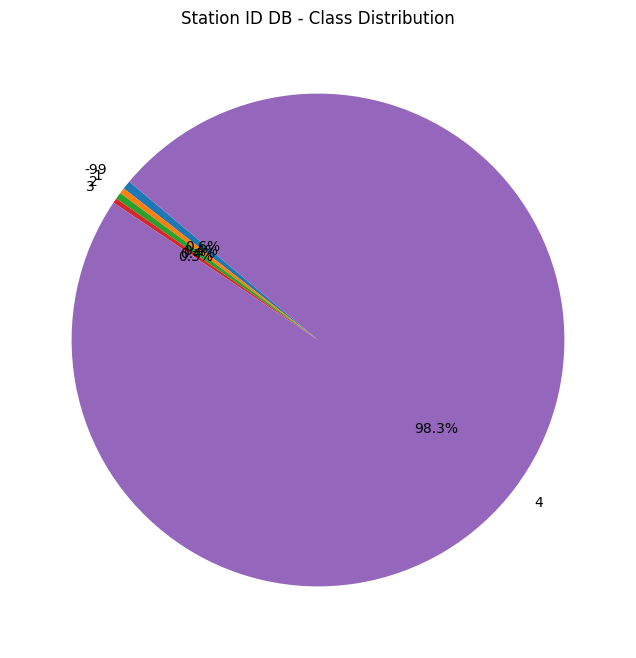

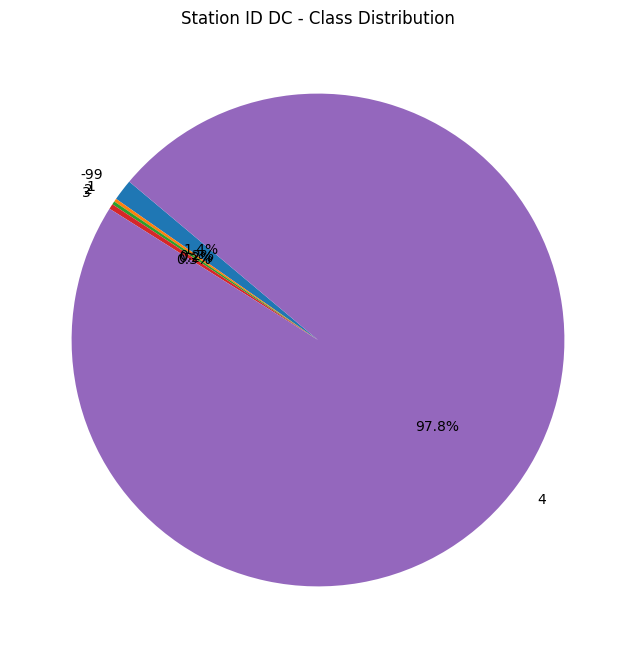

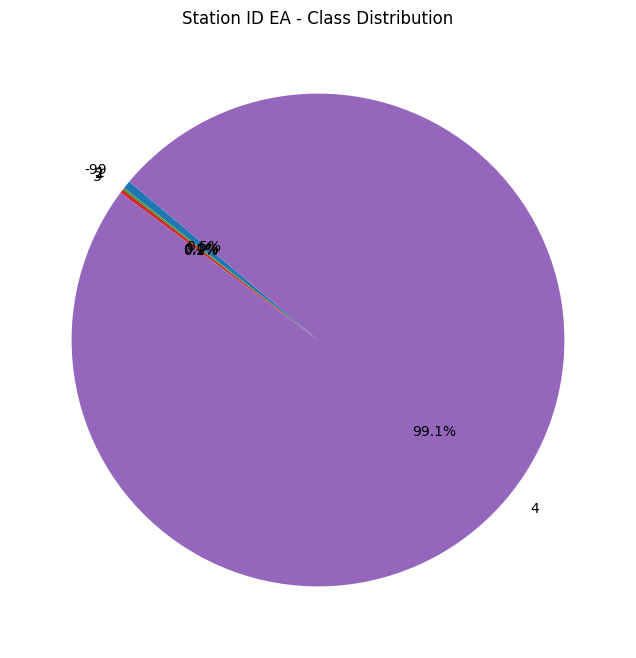

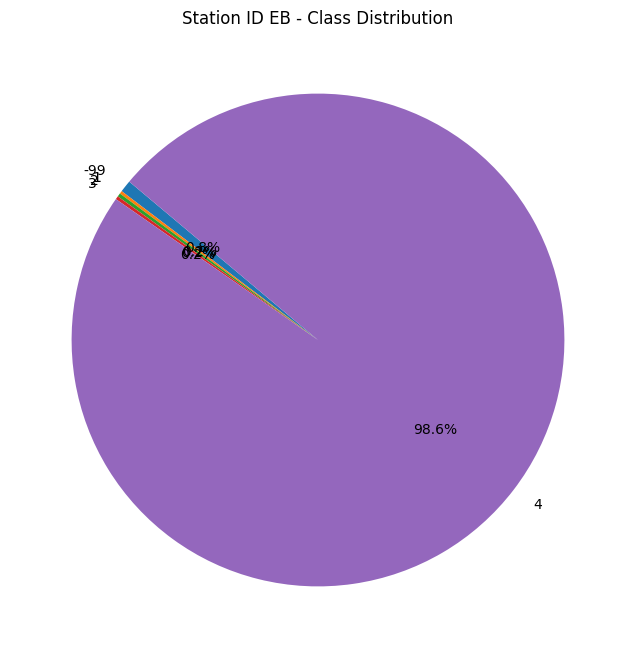

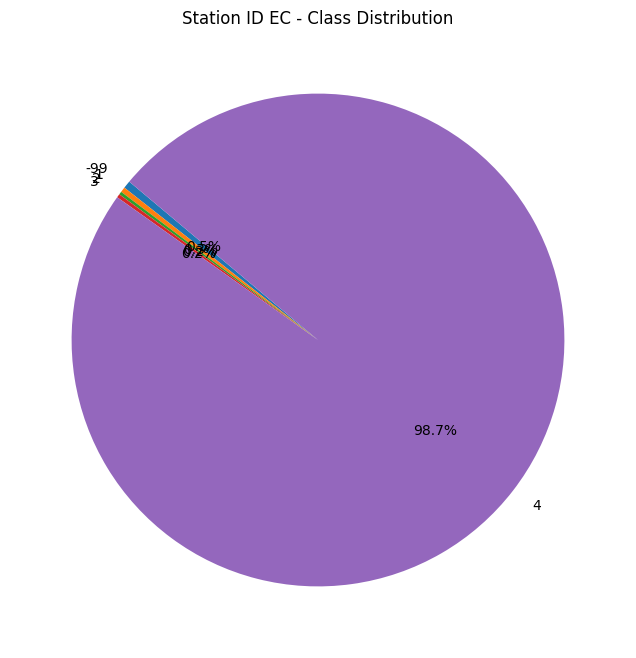

In [ ]:
# stn_id별로 class의 개수를 계산
class_counts_by_stn_id = train_data1.groupby('stn_id')['class'].value_counts().unstack(fill_value=0)

# 각 stn_id별로 파이차트 그리기
for stn_id in class_counts_by_stn_id.index:
    plt.figure(figsize=(8, 8))
    class_counts_by_stn_id.loc[stn_id].plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Station ID {stn_id} - Class Distribution')
    plt.ylabel('')  # y축 라벨 제거
    plt.show()

In [ ]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 필요없는 특성 제거
train_data = train_data.drop(['year','re'], axis=1)
test_data = test_data.drop(['year','re'], axis=1)

In [ ]:
# 안개 발생 모델은 5개지역으로 나뉨으로, 20개 지점을 5개로 축약
# ex) AA -> A, BA ->B로 바꾼다
# 'stn_id' 열에서 첫 글자만 추출하여 축약
train_data['stn_id'] = train_data['stn_id'].str.slice(0, 1)
test_data['stn_id'] = test_data['stn_id'].str.slice(0, 1)

In [ ]:
# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

In [ ]:
test_data['stn_id'].value_counts().sort_index()

stn_id
A    52560
B    52560
C    52560
D    52560
E    52560
Name: count, dtype: int64

In [ ]:
train_data['minute'].unique()

minute
10    526080
30    526080
40    526080
50    526080
20    526079
0     526060
Name: count, dtype: int64

In [ ]:
train_data

,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,class
0,1,1,0,10,A,0.0,0.0,-6.4,38.9,0.0,-2.8,20000.0,4.0
1,1,1,0,20,A,0.0,0.0,-6.3,37.9,0.0,-2.7,20000.0,4.0
2,1,1,0,30,A,0.0,0.0,-6.3,40.0,0.0,-2.6,20000.0,4.0
3,1,1,0,40,A,27.8,0.4,-6.2,39.5,0.0,-2.6,20000.0,4.0
4,1,1,0,50,A,59.7,0.5,-6.1,39.8,0.0,-2.5,20000.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,31,23,10,E,305.3,7.7,2.5,50.2,0.0,-0.9,20000.0,4.0
3156455,12,31,23,20,E,293.8,5.7,2.3,50.1,0.0,-1.3,20000.0,4.0
3156456,12,31,23,30,E,274.2,4.9,2.2,51.0,0.0,-1.4,20000.0,4.0
3156457,12,31,23,40,E,270.3,4.6,2.1,51.7,0.0,-1.6,20000.0,4.0


In [ ]:
train_data['stn_id'].value_counts().sort_index()

stn_id
A    1262584
B     631292
C     315646
D     473469
E     473468
Name: count, dtype: int64

In [ ]:
# 각도 범위를 8개 방향으로 나누는 함수
def degree_to_direction(deg):
    if (337.5 <= deg <= 360) or (0 <= deg < 22.5):
        return 'N'
    elif 22.5 <= deg < 67.5:
        return 'NE'
    elif 67.5 <= deg < 112.5:
        return 'E'
    elif 112.5 <= deg < 157.5:
        return 'SE'
    elif 157.5 <= deg < 202.5:
        return 'S'
    elif 202.5 <= deg < 247.5:
        return 'SW'
    elif 247.5 <= deg < 292.5:
        return 'W'
    elif 292.5 <= deg < 337.5:
        return 'NW'

# 각도 데이터를 방향으로 변환
train_data['direction'] = train_data['ws10_deg'].apply(degree_to_direction)

In [ ]:
#N (북): 337.5° ~ 22.5°
#NE (북동): 22.5° ~ 67.5°
#E (동): 67.5° ~ 112.5°
#SE (남동): 112.5° ~ 157.5°
#S (남): 157.5° ~ 202.5°
#SW (남서): 202.5° ~ 247.5°
#W (서): 247.5° ~ 292.5°
#NW (북서): 292.5° ~ 337.5°

In [ ]:
# 각도 범위를 16개 방향으로 나누는 함수
def degree_to_direction(deg):
    if (348.75 <= deg <= 360) or (0 <= deg < 11.25):
        return 'N'
    elif 11.25 <= deg < 33.75:
        return 'NNE'
    elif 33.75 <= deg < 56.25:
        return 'NE'
    elif 56.25 <= deg < 78.75:
        return 'ENE'
    elif 78.75 <= deg < 101.25:
        return 'E'
    elif 101.25 <= deg < 123.75:
        return 'ESE'
    elif 123.75 <= deg < 146.25:
        return 'SE'
    elif 146.25 <= deg < 168.75:
        return 'SSE'
    elif 168.75 <= deg < 191.25:
        return 'S'
    elif 191.25 <= deg < 213.75:
        return 'SSW'
    elif 213.75 <= deg < 236.25:
        return 'SW'
    elif 236.25 <= deg < 258.75:
        return 'WSW'
    elif 258.75 <= deg < 281.25:
        return 'W'
    elif 281.25 <= deg < 303.75:
        return 'WNW'
    elif 303.75 <= deg < 326.25:
        return 'NW'
    elif 326.25 <= deg < 348.75:
        return 'NNW'

# 각도 데이터를 방향으로 변환
train_data['direction'] = train_data['ws10_deg'].apply(degree_to_direction)


In [ ]:
#N (북) : 348.75° ~ 11.25°
#NNE (북북동) : 11.25° ~ 33.75°
#NE (북동) : 33.75° ~ 56.25°
#ENE (동북동) : 56.25° ~ 78.75°
#E (동) : 78.75° ~ 101.25°
#ESE (동남동) : 101.25° ~ 123.75°
#SE (남동) : 123.75° ~ 146.25°
#SSE (남남동) : 146.25° ~ 168.75°
#S (남) : 168.75° ~ 191.25°
#SSW (남남서) : 191.25° ~ 213.75°
#SW (남서) : 213.75° ~ 236.25°
#WSW (서남서) : 236.25° ~ 258.75°
#W (서) : 258.75° ~ 281.25°
#WNW (서북서) : 281.25° ~ 303.75°
#NW (북서) : 303.75° ~ 326.25°
#NNW (북북서) : 326.25° ~ 348.75°

In [ ]:
len(test_data)

262800

In [ ]:
train_data

,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,class,direction
0,1,1,0,10,A,0.0,0.0,-6.4,38.9,0.0,-2.8,20000.0,4.0,N
1,1,1,0,20,A,0.0,0.0,-6.3,37.9,0.0,-2.7,20000.0,4.0,N
2,1,1,0,30,A,0.0,0.0,-6.3,40.0,0.0,-2.6,20000.0,4.0,N
3,1,1,0,40,A,27.8,0.4,-6.2,39.5,0.0,-2.6,20000.0,4.0,NNE
4,1,1,0,50,A,59.7,0.5,-6.1,39.8,0.0,-2.5,20000.0,4.0,ENE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,31,23,10,E,305.3,7.7,2.5,50.2,0.0,-0.9,20000.0,4.0,NW
3156455,12,31,23,20,E,293.8,5.7,2.3,50.1,0.0,-1.3,20000.0,4.0,WNW
3156456,12,31,23,30,E,274.2,4.9,2.2,51.0,0.0,-1.4,20000.0,4.0,W
3156457,12,31,23,40,E,270.3,4.6,2.1,51.7,0.0,-1.6,20000.0,4.0,W


In [ ]:
train_data.describe()

,month,day,time,minute,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,class
count,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.150549e+06,3.150633e+06,3.152592e+06,3.152843e+06,3.112549e+06,3.067820e+06,3.133943e+06,3.133943e+06
mean,6.521931e+00,1.573276e+01,1.150007e+01,2.500016e+01,1.857501e+02,2.187844e+00,1.342696e+01,6.686834e+01,1.022780e-01,1.608666e+01,1.977727e+04,3.980869e+00
std,3.448969e+00,8.801320e+00,6.922149e+00,1.707819e+01,1.066048e+02,1.760316e+00,1.027291e+01,2.100344e+01,1.581698e-01,1.210345e+01,1.199038e+04,2.038098e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.430000e+01,0.000000e+00,0.000000e+00,-4.900000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,8.540000e+01,9.000000e-01,5.500000e+00,5.130000e+01,0.000000e+00,6.000000e+00,1.250000e+04,4.000000e+00
50%,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,2.098000e+02,1.800000e+00,1.430000e+01,6.870000e+01,0.000000e+00,1.630000e+01,2.000000e+04,4.000000e+00
75%,1.000000e+01,2.300000e+01,1.800000e+01,4.000000e+01,2.770000e+02,3.000000e+00,2.200000e+01,8.470000e+01,1.700000e-01,2.450000e+01,2.000000e+04,4.000000e+00
max,1.200000e+01,3.100000e+01,2.300000e+01,5.000000e+01,3.600000e+02,2.250000e+01,3.780000e+01,1.000000e+02,2.687000e+01,7.010000e+01,6.052500e+04,4.000000e+00


In [ ]:
import matplotlib.pyplot as plt

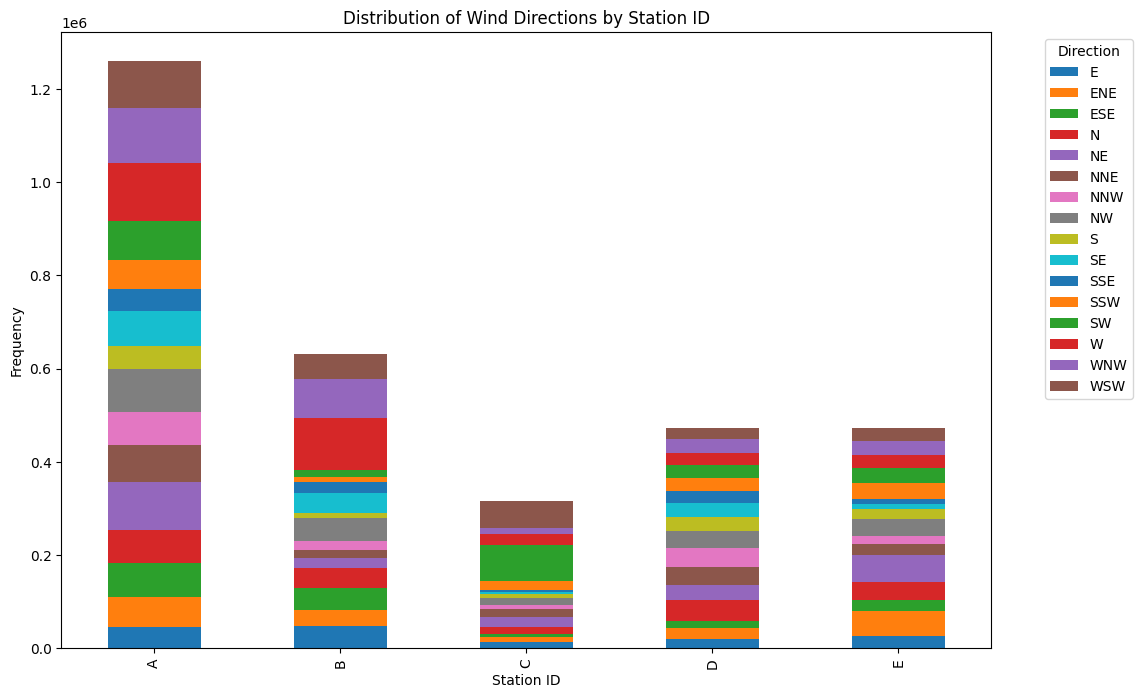

In [ ]:
# stn_id와 방향에 따른 데이터 분포 계산
direction_distribution = train_data.groupby(['stn_id', 'direction']).size().unstack(fill_value=0)

# 막대 그래프 그리기
direction_distribution.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Station ID')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Directions by Station ID')
plt.legend(title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

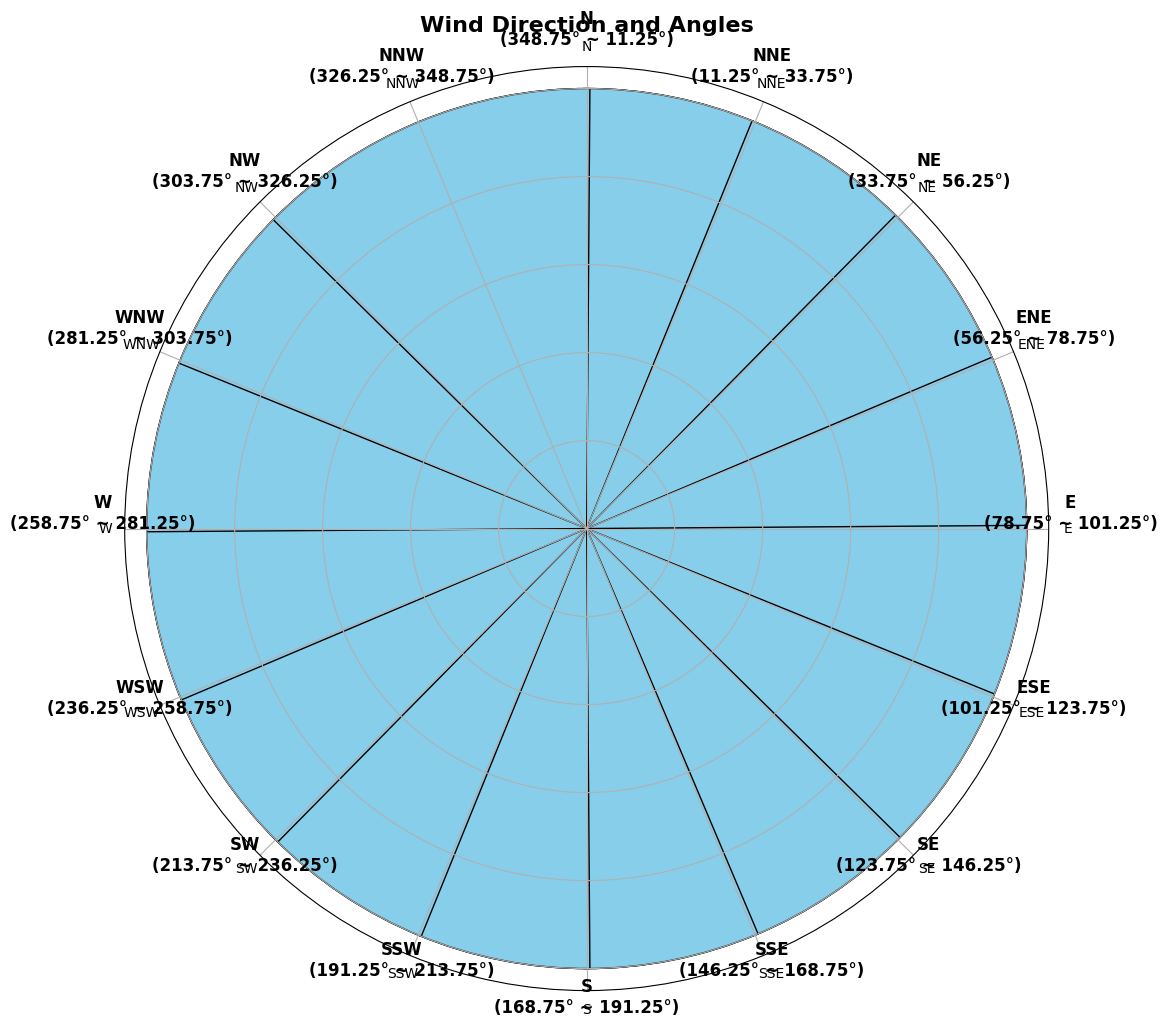

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 방향과 각도 범위 정의
directions = [
    'N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
    'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'
]
angle_ranges = [
    '348.75° ~ 11.25°', '11.25° ~ 33.75°', '33.75° ~ 56.25°', '56.25° ~ 78.75°',
    '78.75° ~ 101.25°', '101.25° ~ 123.75°', '123.75° ~ 146.25°', '146.25° ~ 168.75°',
    '168.75° ~ 191.25°', '191.25° ~ 213.75°', '213.75° ~ 236.25°', '236.25° ~ 258.75°',
    '258.75° ~ 281.25°', '281.25° ~ 303.75°', '303.75° ~ 326.25°', '326.25° ~ 348.75°'
]
angles = [
    0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5,
    180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5
]

# 시각화
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
theta = np.radians(angles)  # 각도를 라디안으로 변환
radii = [1] * len(directions)  # 모든 방향의 반지름은 동일하게 설정

bars = ax.bar(theta, radii, color='skyblue', align='center', edgecolor='black')

# 각도에 따라 레이블 추가
for angle, direction, angle_range in zip(theta, directions, angle_ranges):
    ax.text(angle, 1.1, f"{direction}\n({angle_range})", horizontalalignment='center', size=12, weight='bold')

ax.set_yticklabels([])
ax.set_xticks(theta)
ax.set_xticklabels(directions)

# 북쪽이 위를 가리키도록 설정 및 시계방향 설정
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

plt.title('Wind Direction and Angles', size=16, weight='bold')
plt.show()


### Station ID A
주요 풍향: W (9.83%), WNW (9.36%), NE (8.21%)
특징: 이 스테이션은 서쪽(W)과 서북서(WNW) 방향의 바람이 가장 많이 분포되어 있으며, 북동(NE) 방향의 바람도 상대적으로 많이 나타납니다.

### Station ID B
주요 풍향: W (17.74%), WNW (13.43%), WSW (8.36%)
특징: 서쪽(W)과 서북서(WNW) 방향의 바람이 전체의 상당 부분을 차지하고 있습니다. 이 스테이션은 서쪽 계열의 바람이 지배적입니다.

### Station ID C
주요 풍향: SW (24.42%), WSW (17.88%), NE (6.58%)
특징: 남서(SW)와 서남서(WSW) 방향의 바람이 압도적으로 많습니다. 북동(NE) 방향도 다른 방향에 비해 조금 높은 비율을 보입니다.

### Station ID D
주요 풍향: N (9.84%), NNW (8.75%), NNE (8.16%)
특징: 북쪽(N) 방향의 바람이 가장 많이 나타나며, 북북서(NNW)와 북북동(NNE) 방향도 상당히 높은 비율을 차지하고 있습니다. 전반적으로 북쪽 계열의 바람이 주를 이룹니다.

### Station ID E
주요 풍향: NE (12.53%), ENE (11.30%), N (8.11%)
특징: 북동(NE)과 동북동(ENE) 방향의 바람이 많이 나타납니다. 북(N) 방향도 상당한 비율을 차지합니다. 북동 계열의 바람이 주로 분포합니다.

In [ ]:
 '''
 Station ID A:
  E: 3.63%
  ENE: 5.03%
  ESE: 5.84%
  N: 5.54%
  NE: 8.21%
  NNE: 6.34%
  NNW: 5.72%
  NW: 7.23%
  S: 3.88%
  SE: 6.05%
  SSE: 3.77%
  SSW: 4.97%
  SW: 6.62%
  W: 9.83%
  WNW: 9.36%
  WSW: 7.99%

W (9.83%), WNW (9.36%)가 많긴함.

Station ID B:
  E: 7.62%
  ENE: 5.33%
  ESE: 7.34%
  N: 6.88%
  NE: 3.39%
  NNE: 2.67%
  NNW: 3.32%
  NW: 7.71%
  S: 1.78%
  SE: 6.70%
  SSE: 3.91%
  SSW: 1.46%
  SW: 2.34%
  W: 17.74%
  WNW: 13.43%
  WSW: 8.36%

#WSW (서남서)
#W (서)
#WNW (서북서)  << 데이터 개수가 2위로 많은데도 압도적으로 위 방향이 많음!


Station ID C:
  E: 3.92%
  ENE: 3.74%
  ESE: 1.99%
  N: 4.70%
  NE: 6.58%
  NNE: 5.43%
  NNW: 2.73%
  NW: 5.25%
  S: 2.25%
  SE: 1.28%
  SSE: 1.32%
  SSW: 6.25%
  SW: 24.42%
  W: 7.51%
  WNW: 4.76%
  WSW: 17.88%

#SW (남서)
#WSW (서남서)  압도적 < C개수각 적어서 반영이 많이된거일듯


Station ID D:
  E: 4.03%
  ENE: 4.86%
  ESE: 3.18%
  N: 9.84%
  NE: 6.66%
  NNE: 8.16%
  NNW: 8.75%
  NW: 7.46%
  S: 6.37%
  SE: 6.41%
  SSE: 5.45%
  SSW: 6.02%
  SW: 6.12%
  W: 5.18%
  WNW: 6.24%
  WSW: 5.28%

# 북쪽이 많은편


Station ID E:
  E: 5.66%
  ENE: 11.30%
  ESE: 4.79%
  N: 8.11%
  NE: 12.53%
  NNE: 4.75%
  NNW: 3.64%
  NW: 7.74%
  S: 4.51%
  SE: 2.50%
  SSE: 2.42%
  SSW: 7.15%
  SW: 6.53%
  W: 6.29%
  WNW: 6.02%
  WSW: 6.04%


 #   NE (12.53%), ENE (11.30%), N (8.11%) 특징: 북동(NE)과 동북동(ENE) 방향의 바람많음
  '''

### ... 지역을 예측하는데 풍향의 영향이 컸다고 생각할수있다! 지역별로 안개 발생량은?
### B가 가장 많다! 데이터의 개수가 2위로 많은데도 많은거면... 지역별로 안개 발생량이 다르다 특히 B는
#과연이걸로 지역예측을//..

'\nStation ID A:\n E: 3.63%\n ENE: 5.03%\n ESE: 5.84%\n N: 5.54%\n NE: 8.21%\n NNE: 6.34%\n NNW: 5.72%\n NW: 7.23%\n S: 3.88%\n SE: 6.05%\n SSE: 3.77%\n SSW: 4.97%\n SW: 6.62%\n W: 9.83%\n WNW: 9.36%\n WSW: 7.99%\n\nW (9.83%), WNW (9.36%)가 많긴함. \n\nStation ID B:\n E: 7.62%\n ENE: 5.33%\n ESE: 7.34%\n N: 6.88%\n NE: 3.39%\n NNE: 2.67%\n NNW: 3.32%\n NW: 7.71%\n S: 1.78%\n SE: 6.70%\n SSE: 3.91%\n SSW: 1.46%\n SW: 2.34%\n W: 17.74%\n WNW: 13.43%\n WSW: 8.36%\n\n#WSW (서남서)\n#W (서) \n#WNW (서북서)  << 데이터 개수가 2위로 많은데 압도적으로 위 방향이 많음!\n\n\nStation ID C:\n E: 3.92%\n ENE: 3.74%\n ESE: 1.99%\n N: 4.70%\n NE: 6.58%\n NNE: 5.43%\n NNW: 2.73%\n NW: 5.25%\n S: 2.25%\n SE: 1.28%\n SSE: 1.32%\n SSW: 6.25%\n SW: 24.42%\n W: 7.51%\n WNW: 4.76%\n WSW: 17.88%\n\n#SW (남서)\n#WSW (서남서)  압도적 < C개수각 적어서 반영이 많이된거일듯\n\n\nStation ID D:\n E: 4.03%\n ENE: 4.86%\n ESE: 3.18%\n N: 9.84%\n NE: 6.66%\n NNE: 8.16%\n NNW: 8.75%\n NW: 7.46%\n S: 6.37%\n SE: 6.41%\n SSE: 5.45%\n SSW: 6.02%\n SW: 6.12%\n W: 5.18%\n WNW: 6.24

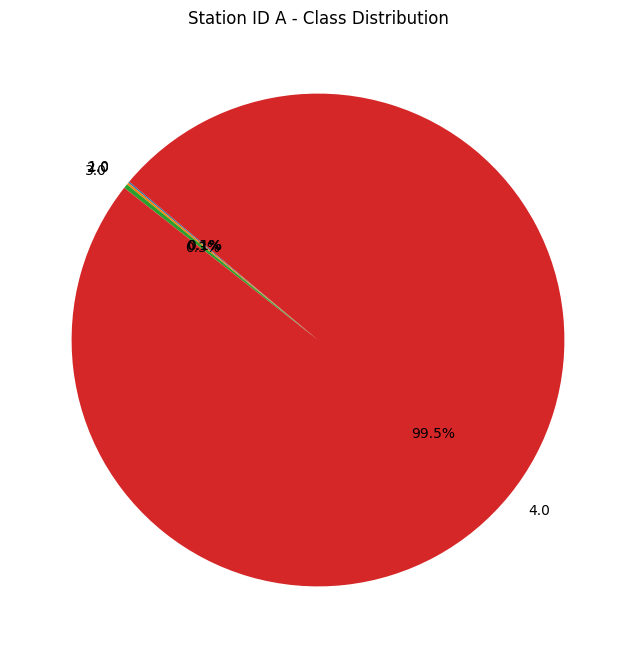

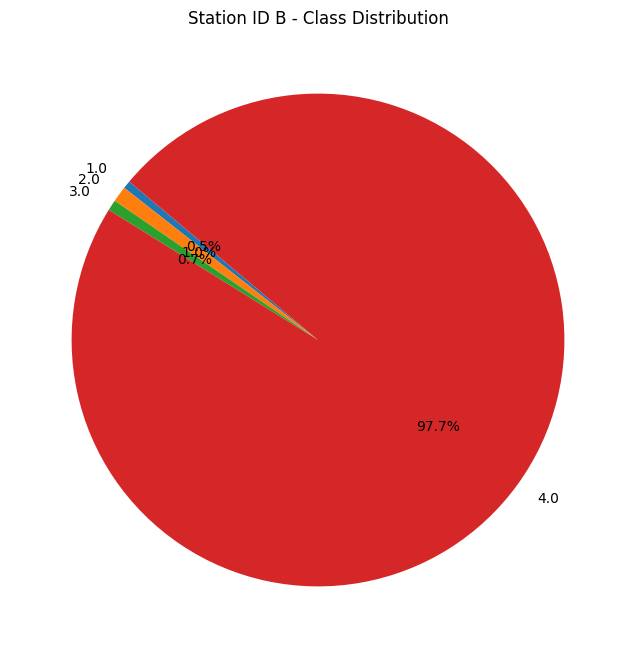

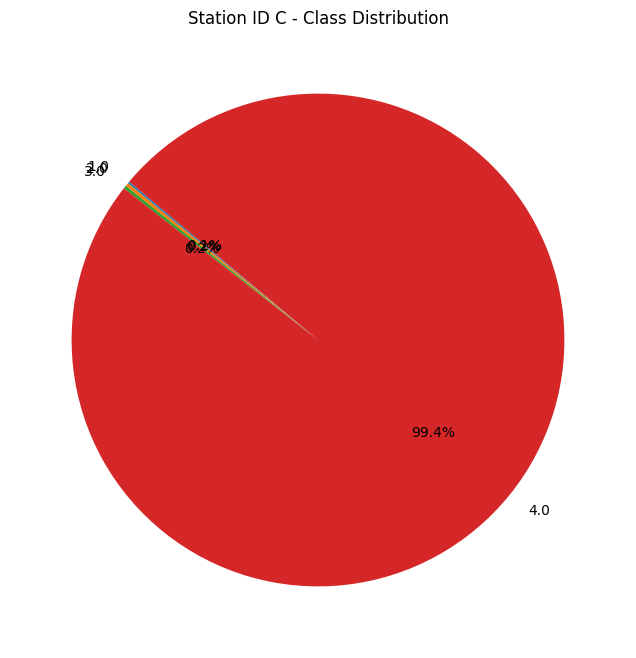

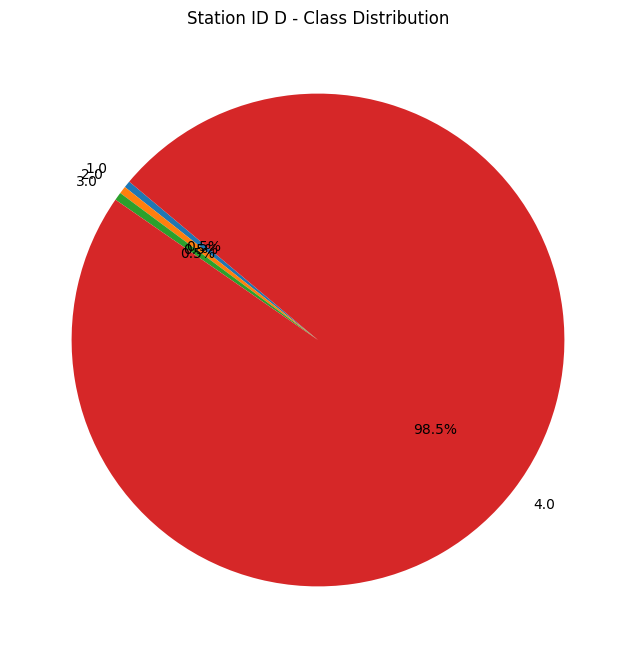

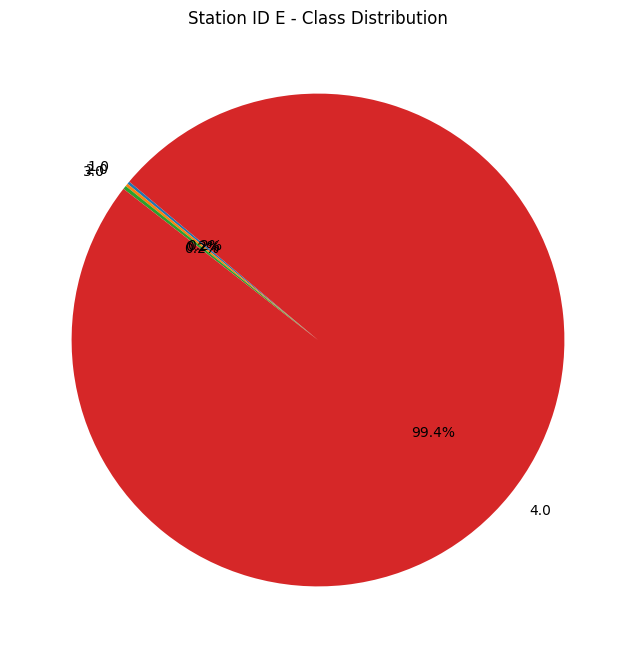

In [ ]:
# stn_id별로 class의 개수를 계산
class_counts_by_stn_id = train_data.groupby('stn_id')['class'].value_counts().unstack(fill_value=0)

# 각 stn_id별로 파이차트 그리기
for stn_id in class_counts_by_stn_id.index:
    plt.figure(figsize=(8, 8))
    class_counts_by_stn_id.loc[stn_id].plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Station ID {stn_id} - Class Distribution')
    plt.ylabel('')  # y축 라벨 제거
    plt.show()

In [ ]:
# stn_id별 비율 계산
direction_distribution_percentage = direction_distribution.div(direction_distribution.sum(axis=1), axis=0) * 100

# stn_id별로 비율이 높은 방향 순서대로 정렬
sorted_direction_distribution_percentage = direction_distribution_percentage.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 정렬된 결과 출력
for stn_id in sorted_direction_distribution_percentage.index:
    print(f"Station ID {stn_id}:")
    sorted_percentages = sorted_direction_distribution_percentage.loc[stn_id]
    for direction, percentage in sorted_percentages.items():
        print(f"  {direction}: {percentage:.2f}%")


Station ID A:
  E: 3.63%
  ENE: 5.03%
  ESE: 5.84%
  N: 5.54%
  NE: 8.21%
  NNE: 6.34%
  NNW: 5.72%
  NW: 7.23%
  S: 3.88%
  SE: 6.05%
  SSE: 3.77%
  SSW: 4.97%
  SW: 6.62%
  W: 9.83%
  WNW: 9.36%
  WSW: 7.99%
Station ID B:
  E: 7.62%
  ENE: 5.33%
  ESE: 7.34%
  N: 6.88%
  NE: 3.39%
  NNE: 2.67%
  NNW: 3.32%
  NW: 7.71%
  S: 1.78%
  SE: 6.70%
  SSE: 3.91%
  SSW: 1.46%
  SW: 2.34%
  W: 17.74%
  WNW: 13.43%
  WSW: 8.36%
Station ID C:
  E: 3.92%
  ENE: 3.74%
  ESE: 1.99%
  N: 4.70%
  NE: 6.58%
  NNE: 5.43%
  NNW: 2.73%
  NW: 5.25%
  S: 2.25%
  SE: 1.28%
  SSE: 1.32%
  SSW: 6.25%
  SW: 24.42%
  W: 7.51%
  WNW: 4.76%
  WSW: 17.88%
Station ID D:
  E: 4.03%
  ENE: 4.86%
  ESE: 3.18%
  N: 9.84%
  NE: 6.66%
  NNE: 8.16%
  NNW: 8.75%
  NW: 7.46%
  S: 6.37%
  SE: 6.41%
  SSE: 5.45%
  SSW: 6.02%
  SW: 6.12%
  W: 5.18%
  WNW: 6.24%
  WSW: 5.28%
Station ID E:
  E: 5.66%
  ENE: 11.30%
  ESE: 4.79%
  N: 8.11%
  NE: 12.53%
  NNE: 4.75%
  NNW: 3.64%
  NW: 7.74%
  S: 4.51%
  SE: 2.50%
  SSE: 2.42%
  SSW:

In [ ]:
train_data['sun10'].corr(train_data['ts'])

0.5506797648988246

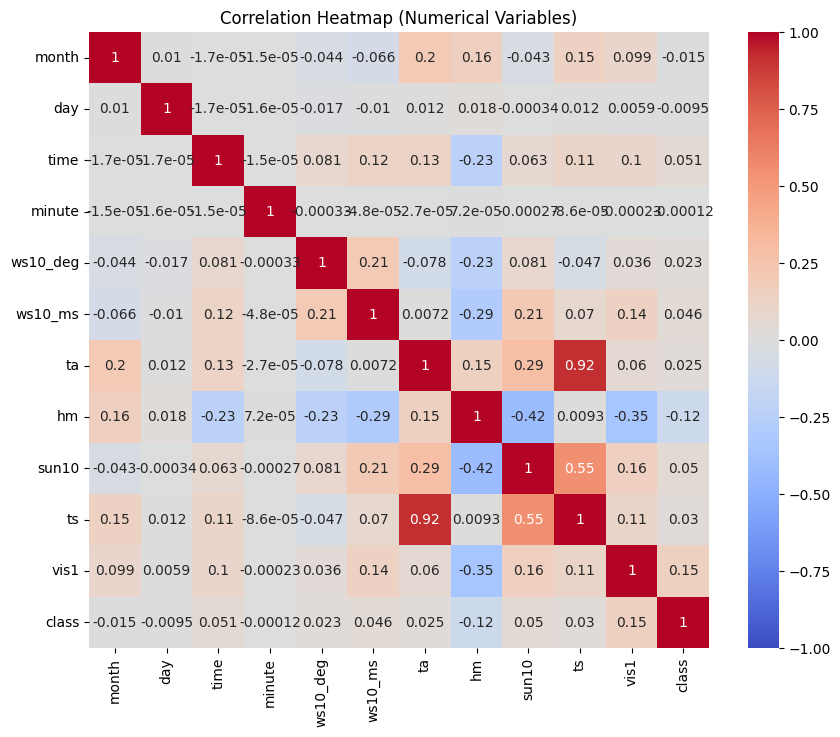

In [ ]:
import seaborn as sns

# 모든 변수 간 상관관계 계산
correlation_matrix = train_data.select_dtypes(include=[float, int]).corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical Variables)')
plt.show()

In [ ]:
#ta ts
# sun10 ts
다중공선성을 파악하기위해.....

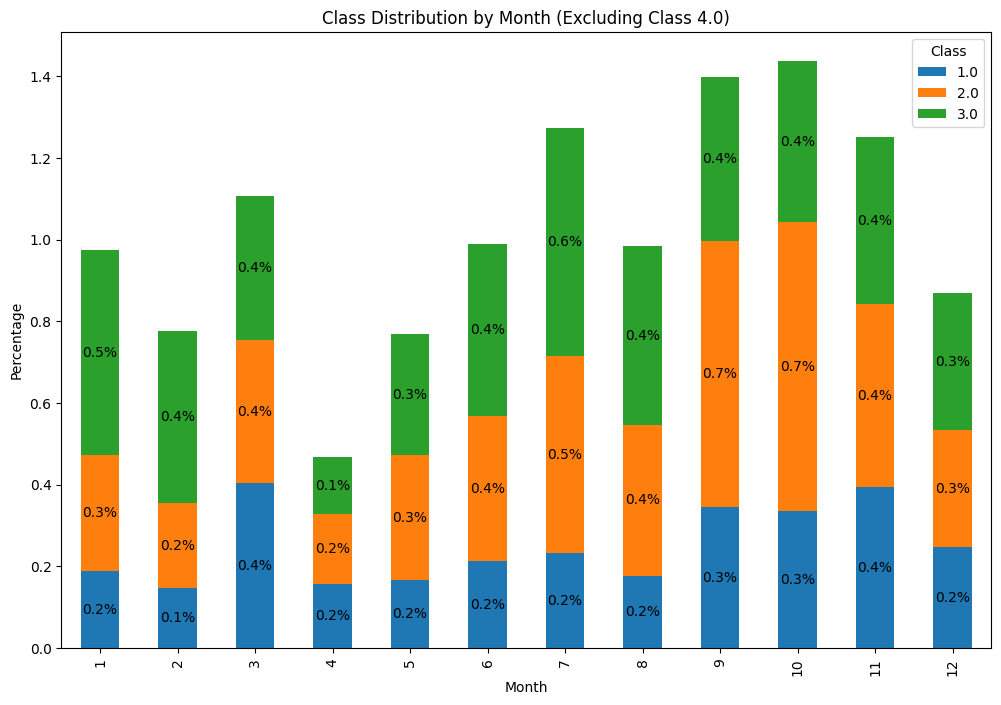

In [ ]:

# month별 class의 개수 계산
class_counts_by_month = train_data.groupby(['month', 'class']).size().unstack(fill_value=0)

# month별 비율 계산
class_percentage_by_month = class_counts_by_month.div(class_counts_by_month.sum(axis=1), axis=0) * 100

# Class 4.0 제외
class_percentage_by_month_excluding_class_4 = class_percentage_by_month.drop(columns=[4.0], errors='ignore')

# 막대 그래프 그리기
ax = class_percentage_by_month_excluding_class_4.plot(kind='bar', stacked=True, figsize=(12, 8))

# 비율을 숫자로 출력
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 비율이 0이 아닌 경우에만 표시
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center')

plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Class Distribution by Month (Excluding Class 4.0)')
plt.legend(title='Class')
plt.show()

In [ ]:
# 시계열?!.. 당연한거긴 한데

In [ ]:
train_data

,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,class,direction
0,1,1,0,10,A,0.0,0.0,-6.4,38.9,0.0,-2.8,20000.0,4.0,N
1,1,1,0,20,A,0.0,0.0,-6.3,37.9,0.0,-2.7,20000.0,4.0,N
2,1,1,0,30,A,0.0,0.0,-6.3,40.0,0.0,-2.6,20000.0,4.0,N
3,1,1,0,40,A,27.8,0.4,-6.2,39.5,0.0,-2.6,20000.0,4.0,NNE
4,1,1,0,50,A,59.7,0.5,-6.1,39.8,0.0,-2.5,20000.0,4.0,ENE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,31,23,10,E,305.3,7.7,2.5,50.2,0.0,-0.9,20000.0,4.0,NW
3156455,12,31,23,20,E,293.8,5.7,2.3,50.1,0.0,-1.3,20000.0,4.0,WNW
3156456,12,31,23,30,E,274.2,4.9,2.2,51.0,0.0,-1.4,20000.0,4.0,W
3156457,12,31,23,40,E,270.3,4.6,2.1,51.7,0.0,-1.6,20000.0,4.0,W


In [ ]:
train_data.isnull().sum()

month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
hm           3616
sun10       43910
ts          88639
vis1        22516
class       22516
dtype: int64

In [ ]:
train_data.nunique()

month          12
day            31
time           24
minute          6
stn_id          5
ws10_deg     3601
ws10_ms       202
ta            619
hm            960
sun10         362
ts            728
vis1        51036
class           4
dtype: int64

In [ ]:
train_data.isnull().any(axis=1).sum()


150341

In [ ]:
# 결측치 있는 column 분리
cols_with_na = train_data.columns[train_data.isna().any()]
cols_no_na = train_data.columns[~train_data.columns.isin(cols_with_na)]

# vis1의 결측값을 먼저 대체
vis1_imputer = IterativeImputer(random_state=42)
train_data[['vis1']] = vis1_imputer.fit_transform(train_data[['vis1']])

# vis1 값을 바탕으로 class 결측값 대체
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

train_data['class'] = train_data.apply(fill_class, axis=1)

# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 Iterative Imputer 사용
# 결측치 보간을 2단계로 나눈 이유는, test에는 목표변수인 class, 시정구간을 알 수 있는 변수 인 vis1이 없기 때문
# iteratvie 객체 초기화
cols_with_na_no_class = cols_with_na.drop(['vis1','class'])
imputer = IterativeImputer(random_state=42)
train_na = pd.DataFrame(imputer.fit_transform(train_data[cols_with_na_no_class]), columns=cols_with_na_no_class)
test_na = pd.DataFrame(imputer.transform(test_data[cols_with_na_no_class]), columns=cols_with_na_no_class)

# 결측치가 없는 열을 추가
train_imputed = pd.concat([train_na, train_data.drop(columns=cols_with_na_no_class)], axis=1)
test_imputed = pd.concat([test_na, test_data.drop(columns=cols_with_na_no_class)], axis=1)

# 파생 변수 추가
train_imputed['Temp_Diff'] = train_imputed['ta'] - train_imputed['ts']
test_imputed['Temp_Diff'] = test_imputed['ta'] - test_imputed['ts']

train_imputed['Humidity_Wind_Interaction'] = train_imputed['hm'] / (train_imputed['ws10_ms'] + 1)
test_imputed['Humidity_Wind_Interaction'] = test_imputed['hm'] / (test_imputed['ws10_ms'] + 1)

train_imputed['Fog_Likelihood_Index'] = (train_imputed['Temp_Diff'] * train_imputed['hm']) / (train_imputed['ws10_ms'] + 1)
test_imputed['Fog_Likelihood_Index'] = (test_imputed['Temp_Diff'] * test_imputed['hm']) / (test_imputed['ws10_ms'] + 1)

train_imputed['Dew_Point'] = 243.04 * (np.log(train_imputed['hm']/100) + ((17.625*train_imputed['ta'])/(243.04+train_imputed['ta']))) / (17.625 - np.log(train_imputed['hm']/100) - ((17.625*train_imputed['ta'])/(243.04+train_imputed['ta'])))
test_imputed['Dew_Point'] = 243.04 * (np.log(test_imputed['hm']/100) + ((17.625*test_imputed['ta'])/(243.04+test_imputed['ta']))) / (17.625 - np.log(test_imputed['hm']/100) - ((17.625*test_imputed['ta'])/(243.04+test_imputed['ta'])))

# 필요없는 feature 제거
train_imputed = train_imputed.drop(['ts'], axis=1)
test_imputed = test_imputed.drop(['ts'], axis=1)


In [ ]:
# 범주형 변수 인코딩
cat_cols = train_imputed.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cat_encoded = pd.DataFrame(encoder.fit_transform(train_imputed[cat_cols]))
test_cat_encoded = pd.DataFrame(encoder.transform(test_imputed[cat_cols]))

train_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)
test_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)

# 인코딩된 범주형 변수와 수치형 변수를 다시 합침
train_imputed = pd.concat([train_imputed.drop(columns=cat_cols), train_cat_encoded], axis=1)
test_imputed = pd.concat([test_imputed.drop(columns=cat_cols), test_cat_encoded], axis=1)


In [ ]:
# 처리과정 후 생기는 결측치는 그냥 제거
train_imputed = train_imputed.dropna()
test_imputed = test_imputed.dropna()

#XGBOOST

In [ ]:
# 특징과 라벨 분리
X = train_imputed.drop(['class','vis1'], axis=1)
y = train_imputed['class']

# 오버샘플링 적용 전 클래스 비율 확인
print("Original class distribution:")
print(y.value_counts(normalize=True))

# 각 클래스의 샘플 개수 확인
class_counts = y.value_counts()

# 샘플링 전략 설정
sampling_strategy = {
    1: int(class_counts[1] * 20.0),  # 클래스 1의 목표 샘플 수
    2: int(class_counts[2] * 20.0),  # 클래스 2의 목표 샘플 수
    3: int(class_counts[3] * 20.0),  # 클래스 3의 목표 샘플 수
    4: class_counts[4]  # 클래스 4는 원래 개수 유지
}

# 오버샘플링 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 적용 후 클래스 비율 확인
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

Original class distribution:
class
4.0    0.989820
3.0    0.003859
2.0    0.003830
1.0    0.002492
Name: proportion, dtype: float64
Class distribution after SMOTE:
class
4.0    0.866343
3.0    0.050661
2.0    0.050278
1.0    0.032717
Name: proportion, dtype: float64


In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

[0]	eval-mlogloss:1.05894	train-mlogloss:1.22352
[1]	eval-mlogloss:0.88246	train-mlogloss:1.12699
[2]	eval-mlogloss:0.77033	train-mlogloss:1.06073
[3]	eval-mlogloss:0.69230	train-mlogloss:1.01246
[4]	eval-mlogloss:0.63619	train-mlogloss:0.97654
[5]	eval-mlogloss:0.59557	train-mlogloss:0.94821
[6]	eval-mlogloss:0.56583	train-mlogloss:0.92533
[7]	eval-mlogloss:0.54229	train-mlogloss:0.90584
[8]	eval-mlogloss:0.52524	train-mlogloss:0.89141
[9]	eval-mlogloss:0.51124	train-mlogloss:0.87934
[10]	eval-mlogloss:0.49888	train-mlogloss:0.86863
[11]	eval-mlogloss:0.48589	train-mlogloss:0.85530
[12]	eval-mlogloss:0.47504	train-mlogloss:0.84645
[13]	eval-mlogloss:0.46653	train-mlogloss:0.83697
[14]	eval-mlogloss:0.45850	train-mlogloss:0.82949
[15]	eval-mlogloss:0.44963	train-mlogloss:0.82114
[16]	eval-mlogloss:0.44359	train-mlogloss:0.81473
[17]	eval-mlogloss:0.43624	train-mlogloss:0.80818
[18]	eval-mlogloss:0.42965	train-mlogloss:0.80099
[19]	eval-mlogloss:0.42221	train-mlogloss:0.79400
[20]	eval-

In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

In [ ]:
bst

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
#  Time에따라 다를듯 Minute 은 영향은 있겠지만 과연 유의미할까
# re가 왜 필요한건지?... 강수 전에 안개가 많지 않을까. 강수시에는 안개가 많다. 강수 직후에는 안개가 없지 않을까
# 전날 일사량이 많으면 안개가 많을것같다
# 풍속이 크면 안개가 없을것이다.
# 풍향이 과연 관련이 있을까? 지역에따라 풍향이 다를텐데? 동
# 지역별로 안개의 종류가 다르다고 한다 pdf의 개념을 적용시키고 새로운 변수를 만ㄴ들어보자!
# 변화량변수 그라디언트를 만들어보자
# 일교차 크면 당연히 많이 발생 그러나 데이터가 반영 안할듯 시계열로?...


Feature Importance:
                      Feature  Importance
0                    ws10_deg     29616.0
11       Fog_Likelihood_Index     22847.0
9                   Temp_Diff     19900.0
3                          hm     19740.0
6                         day     17560.0
2                          ta     14948.0
8                      minute     14703.0
12                  Dew_Point     13622.0
7                        time     13602.0
10  Humidity_Wind_Interaction     12446.0
1                     ws10_ms     11734.0
4                       sun10      9579.0
5                       month      9258.0
16                   stn_id_D      4018.0
13                   stn_id_A      3962.0
14                   stn_id_B      3760.0
17                   stn_id_E      2569.0
15                   stn_id_C      2216.0


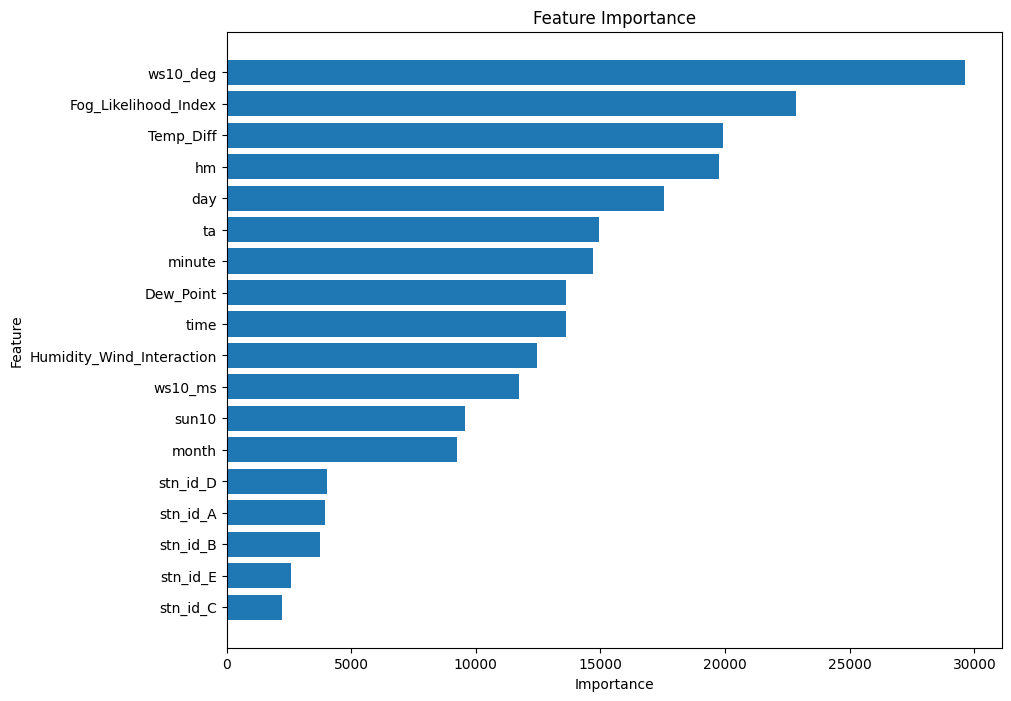

In [ ]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# 각 컬럼에 의미를 부여...
# 풀어쓰기
# shap로 선 부넉 후 도메인 적용

In [ ]:
# 테스트 데이터 예측
dtest = xgb.DMatrix(test_imputed)
y_test_pred = bst.predict(dtest)

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) + 1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

fog_test.class
4    256812
2      2678
3      2382
1       928
Name: count, dtype: int64

In [ ]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>